## 25.0 Refining Chinese rule-based ABSA

- Author: Nana (Ching Wen Yang)
- Created at: 2022.08.01

**Goals**
- Refine by dependency by POS tags
**Reference**
- CKIP part of speech tagging scheme: https://ckip.iis.sinica.edu.tw/CKIP/paper/Sinica%20Corpus%20user%20manual.pdf
    - Na: Common Noun
    - Nb: Proper Noun
    - Nc: Place Noun
    - Nd: Time Noun


In [255]:
import sys, os
import pandas as pd

### parsing sents to dep trees

In [256]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
'''path of source codes'''

root_path = '/share/home/nana2929/'
DepTree_path = '/share/home/nana2929/repo/src/'
for x in [root_path, DepTree_path]:
    if x not in sys.path:
        sys.path.append(x)

import chyiin_ch_parser
from chyiin_ch_parser import dependency_parser
from DepTree import DepTree
ch_parser = dependency_parser.chinese_parser(port=2022, device_id=1) # the port that server_process runs on 

In [258]:
test_sents = ['西瓜很好吃，老闆娘人很好。', '鮮蝦蒸餃很不錯，多汁，但是全店衛生很糟。', 
              '水餃和湯都不錯，但小菜不太好吃', '雞肉和大滷麵都不喜歡', '一顆的份量就好大一個，還吃的到干貝一絲一絲的',
              '食物部分很讚！也很平價，薯餅塔很推薦，裡面還有牽長長的乳酪絲，泡菜燒肉蛋餅很入味',
             '店內提供多種口味拉麵，主要以豚骨湯底為主，還有混合魚系湯頭，整體喝起來濃郁卻不膩，可以一口接一口喝。',
             '整體吃下來口味偏鹹完全不需要加任何醬料，必須配很多飯才會爽。', 
              '宮保蝦球很辣，麻香。其他都好吃。',
             '推薦的：鹹蛋苦瓜、煎豬肝、炒菜類、老皮嫩豆腐、松阪豬肉、金沙南瓜、炒海瓜子等',
              '三杯中卷裡面的中卷很少，大多是薑片跟洋蔥，不過這個價格也是可以了。',
              '口味稍偏重，每道菜的配料都很足，但超適合配飯，佐料自取吃到飽很貼心，有機會會再訪',
              '出餐快、口味濃、氣氛佳，適合大吃大喝、放心喧嘩的好地方↖(^ω^)↗',
             '最愛老皮嫩肉跟炒羊肉平價又好吃']

In [259]:
store = {}
for test_sent in test_sents:
    ws, pos, deptree = ch_parser.output(test_sent)  
    store[test_sent] = (ws, pos, deptree)

### 0628爬的松園牛肉麵評論

In [260]:
filepath = f'../data/0628-beef-noodles/review_clean_parsed.pkl'
df = pd.read_pickle(filepath)

In [261]:
# s, (ws, pos, tree) = list(store.items())[8] # 不太好：5, # '其他 Neqa'不在我定義的Nouns裡
# r = {'sentence': s,
#     'word_seg': ws,
#     'pos': pos, 
#     'dependency_parse': tree}
filepath = f'../data/0628-beef-noodles/review_clean_parsed.pkl'
import random 
rindex = random.randint(0, len(df)-1)
print(rindex)
df = pd.read_pickle(filepath) # 不是neg抓不出來...(parser給標籤的問題）
row = df.iloc[rindex]
print(row['pos'])
print(row['dependency_parse'])
tree = DepTree(row, outdir = './')
tree.predict()

INFO:root:== DepTree ==
INFO:root:attrs:    	 .pos, .ws, .depparse, .dG, .undG, .aspects, .opinions
INFO:root:functions:	 predict(), to_image()
INFO:root:finished loading aspect lexicon.
INFO:root:finished loading opinion lexicon.


28
[(0, 'root root'), (1, '個人 Nh'), (2, '覺得 VK'), (3, '口味 Na'), (4, '普通 VH')]
[('2 - 覺得 VK', '1 - 個人 Nh', 'nsubj'), ('0 - root root', '2 - 覺得 VK', 'root'), ('4 - 普通 VH', '3 - 口味 Na', 'nsubj'), ('2 - 覺得 VK', '4 - 普通 VH', 'ccomp')]


INFO:root:[lexicon-based] detected aspects: []
INFO:root:[lexicon-based] detected opinions: [{'id': 4, 'token': '普通', 'polarity': 'neutral'}]
INFO:root:[Rule 1] Detect NOUN neighbor in subtree; new aspect 口味 is added.
INFO:root:marking: [] for aspect; <> for opinion


(defaultdict(list, {'口味': [('普通', 'neutral')]}), '個人覺得[口味]<普通>')

### 0705 測試 negation, conjunction 用的自製評論

In [286]:
import random
filepath = f'../data/0705-special-cases/0705-dep-testdata_parsed.pkl' 
df = pd.read_pickle(filepath)
rindex = random.randint(0, len(df)-1)
print(rindex)
row = df.iloc[rindex]
print(row['pos'])
print(row['dependency_parse'])
tree = DepTree(row, outdir = './')
tree.predict()

INFO:root:== DepTree ==
INFO:root:attrs:    	 .pos, .ws, .depparse, .dG, .undG, .aspects, .opinions
INFO:root:functions:	 predict(), to_image()
INFO:root:finished loading aspect lexicon.
INFO:root:finished loading opinion lexicon.


10
[(0, 'root root'), (1, '牛肉麵 Na'), (2, '的 DE'), (3, '湯 Na'), (4, '和 Caa'), (5, '麵 Na'), (6, '都 D'), (7, '很 Dfa'), (8, '好吃 VH')]
[('5 - 麵 Na', '1 - 牛肉麵 Na', 'assmod'), ('1 - 牛肉麵 Na', '2 - 的 DE', 'assm'), ('5 - 麵 Na', '3 - 湯 Na', 'conj'), ('5 - 麵 Na', '4 - 和 Caa', 'cc'), ('8 - 好吃 VH', '5 - 麵 Na', 'nsubj'), ('8 - 好吃 VH', '6 - 都 D', 'advmod'), ('8 - 好吃 VH', '7 - 很 Dfa', 'advmod'), ('0 - root root', '8 - 好吃 VH', 'root')]


INFO:root:[lexicon-based] detected aspects: [{'id': 1, 'token': '牛肉麵'}, {'id': 3, 'token': '湯'}, {'id': 5, 'token': '麵'}]
INFO:root:[lexicon-based] detected opinions: [{'id': 8, 'token': '好吃', 'polarity': 'positive'}]
INFO:root:[Rule 1] Detect NOUN neighbor in subtree; new aspect 麵 is added.
INFO:root:[Rule 2] Detect conjunction beween existing aspect 麵 and node 湯; new aspect 湯 is added.
INFO:root:marking: [] for aspect; <> for opinion


(defaultdict(list, {'湯': [('好吃', 'positive')], '麵': [('好吃', 'positive')]}),
 '牛肉麵的[湯]和[麵]都很<好吃>')

### 0801自己找的一些評論 
老師的例子、Google上抓一些


In [270]:
rindex_ = random.randint(0, len(test_sents)-1) 
print(f'rindex_ {rindex_}')
s, (ws, pos, tree) = list(store.items())[-1] 
print(pos)
# good: 0 (老師給的例子), 1, 2, 5 (rule 1)
# not so good: 4 ('其他 Neqa'不在我定義的Nouns裡), 
# not so good: 12 用文字距離去停止opinion-aspect太長距離的連結

r = {'sentence': s,
    'word_seg': ws,
    'pos': pos, 
    'dependency_parse': tree}
tree = DepTree(r, outdir = './')
tree.predict()

INFO:root:== DepTree ==
INFO:root:attrs:    	 .pos, .ws, .depparse, .dG, .undG, .aspects, .opinions
INFO:root:functions:	 predict(), to_image()
INFO:root:finished loading aspect lexicon.
INFO:root:finished loading opinion lexicon.


rindex_ 7
[(0, 'root root'), (1, '最愛 Na'), (2, '老皮嫩肉 Na'), (3, '跟 Caa'), (4, '炒 VC'), (5, '羊肉 Na'), (6, '平價 Na'), (7, '又 D'), (8, '好吃 VH')]


INFO:root:[lexicon-based] detected aspects: [{'id': 5, 'token': '羊肉'}]
INFO:root:[lexicon-based] detected opinions: [{'id': 6, 'token': '平價', 'polarity': 'positive'}, {'id': 8, 'token': '好吃', 'polarity': 'positive'}]
INFO:root:[Rule 1] Detect NOUN neighbor in subtree; new aspect 老皮嫩肉 is added.
INFO:root:marking: [] for aspect; <> for opinion


(defaultdict(list,
             {'羊肉': [('平價', 'positive'), ('好吃', 'positive')],
              '老皮嫩肉': [('平價', 'positive'), ('好吃', 'positive')]}),
 '最愛[老皮嫩肉]跟炒[羊肉]<平價>又<好吃>')

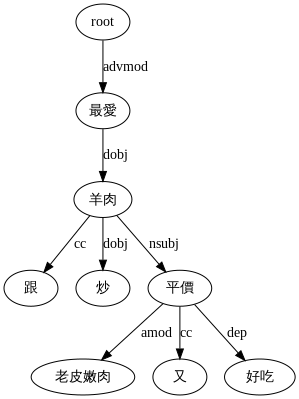

In [271]:
tree.to_image()

### output

In [ ]:
# 做成dictionary

### test subtree algorithms

In [264]:
from networkx.algorithms.traversal.depth_first_search import dfs_tree
print(tree.nodes)
subtree_at3 = dfs_tree(tree.dG, 3) # 好吃
subtree_at7 = dfs_tree(tree.dG, 7) # 好

[(0, 'root', 'root'), (1, '推薦', 'VC'), (2, '的', 'DE'), (3, '：', 'COLONCATEGORY'), (4, '鹹蛋苦瓜', 'Na'), (5, '、', 'PAUSECATEGORY'), (6, '煎', 'VC'), (7, '豬肝', 'Na'), (8, '、', 'PAUSECATEGORY'), (9, '炒菜類', 'Na'), (10, '、', 'PAUSECATEGORY'), (11, '老皮嫩', 'Nb'), (12, '豆腐', 'Na'), (13, '、', 'PAUSECATEGORY'), (14, '松阪', 'Nb'), (15, '豬肉', 'Na'), (16, '、', 'PAUSECATEGORY'), (17, '金沙南瓜', 'Na'), (18, '、', 'PAUSECATEGORY'), (19, '炒海瓜子', 'Na'), (20, '等', 'Cab')]


In [265]:
# test subtree 
subtree_at3.nodes

NodeView((3,))

In [266]:
subtree_at7.nodes

NodeView((7, 4, 6))